In [ ]:
import os, sys
import gymnasium as gym
import time
import numpy as np
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt

import text_flappy_bird_gym

In [3]:
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)

print(env.observation_space)
print(env.action_space)
print(env.action_space.n)

Tuple(Discrete(14), Discrete(22, start=-11))
Discrete(2)
2


# Utils

In [ ]:

def plot_policy(policy_fn, state_space, action_labels):
    """
    Plots the chosen action for each state in the state space.
    """
    state_space_x = sorted(set(state[0] for state in state_space))
    state_space_y = sorted(set(state[1] for state in state_space))
    
    policy_grid = np.full((len(state_space_y), len(state_space_x)), -1, dtype=int)
    for state in state_space:
        x, y = state
        action = policy_fn(state)
        row = state_space_y.index(y) # row 0 corresponds to the lowest y value.
        col = state_space_x.index(x)
        policy_grid[row, col] = action

    fig, ax = plt.subplots(figsize=(10, 8))
    cax = ax.imshow(policy_grid, cmap='viridis', interpolation='nearest', origin='lower')
    cbar = fig.colorbar(cax, ticks=range(len(action_labels)))
    cbar.ax.set_yticklabels(action_labels)
    ax.set_title('Policy Visualization: Chosen Actions for Each State')
    ax.set_xlabel('dx')
    ax.set_ylabel('dy')

    ax.set_xticks(np.arange(len(state_space_x)))
    ax.set_xticklabels(state_space_x)
    ax.set_yticks(np.arange(len(state_space_y)))
    ax.set_yticklabels(state_space_y)
    
    ax.invert_xaxis()
    ax.invert_yaxis() 
    
    plt.show()

def plot_value_function(Q, state_space):
    """
    Plots a heatmap of state values based on the action-value function Q.
    """
    state_space_x = sorted(set(state[0] for state in state_space))
    state_space_y = sorted(set(state[1] for state in state_space))
    
    value_grid = np.zeros((len(state_space_y), len(state_space_x)))
    for state in state_space:
        x, y = state
        if state in Q:
            value = np.max(Q[state])
            row = state_space_y.index(y)
            col = state_space_x.index(x)
            value_grid[row, col] = value

    fig, ax = plt.subplots(figsize=(10, 8))
    cax = ax.imshow(value_grid, cmap='hot', interpolation='nearest', origin='lower')
    fig.colorbar(cax)
    ax.set_title('State Value Heatmap')
    ax.set_xlabel('dx')
    ax.set_ylabel('dy')
    
    ax.set_xticks(np.arange(len(state_space_x)))
    ax.set_xticklabels(state_space_x)
    ax.set_yticks(np.arange(len(state_space_y)))
    ax.set_yticklabels(state_space_y)
    
    ax.invert_xaxis()
    ax.invert_yaxis()
    
    plt.show()


# Monte-Carlo Control

In [ ]:
# Some of this code is taken from the 4th lab  of the class with MC control in blackjack

class MCCAgent:
    def __init__(self, env, alpha=0.5, gamma=0.9, eps_start=1.0, eps_decay=.99999, eps_min=0.05, max_steps=1000):
        self.env = env
        self.nA = env.action_space.n
        self.Q = defaultdict(lambda: np.zeros(self.nA))
        self._policy = defaultdict(lambda: np.random.randint(self.nA))
        self.rewards = []

        self.alpha = alpha
        self.gamma = gamma
        self.eps_start = eps_start
        self.eps_decay = eps_decay
        self.eps_min = eps_min

        self.max_steps = max_steps
    
    def get_probs(self, Q_s, epsilon):
        """ obtains the action probabilities corresponding to epsilon-greedy policy """
        policy_s = np.ones((self.nA)) * epsilon / self.nA
        best_a = np.argmax(Q_s)
        policy_s[best_a] = 1 - epsilon + (epsilon / self.nA)
        return policy_s
    
    def update_Q(self, episode):
        """ updates the action-value function estimate using the most recent episode """
        states, actions, rewards = zip(*episode)
        # prepare for discounting
        discounts = np.array([self.gamma**i for i in range(len(rewards)+1)])
        for i, state in enumerate(states):
            old_Q = self.Q[state][actions[i]]
            self.Q[state][actions[i]] = old_Q + self.alpha * (sum(rewards[i:] * discounts[:-(i+1)]) - old_Q)
     
    def generate_episode(self, epsilon):
        """ generates an episode from following the epsilon-greedy policy """
        episode = []
        cummulative_reward = 0
        step = 0
        state, _ = self.env.reset()
        while True:
            action = np.random.choice(np.arange(self.nA), p=self.get_probs(self.Q[state], epsilon)) \
                                        if state in self.Q else self.env.action_space.sample()

            next_state, reward, done, _, info = self.env.step(action)
            episode.append((state, action, reward))
            cummulative_reward += reward
            state = next_state
            step += 1
            if done or step >= self.max_steps:
                self.rewards.append(cummulative_reward)
                break
        return episode

    def train(self, num_episodes):
        epsilon = self.eps_start
        for _ in tqdm(range(1, num_episodes+1)):
            epsilon = max(epsilon*self.eps_decay, self.eps_min)
            episode = self.generate_episode(epsilon) 
            self.update_Q(episode)

        self._policy = dict((k,np.argmax(v)) for k, v in self.Q.items())
    
    def policy(self, state):
        return self._policy.get(state, 0)



100%|██████████| 20000/20000 [00:05<00:00, 3791.15it/s]


Mean reward: 12.49805
Reward std: 6.4506043280843075


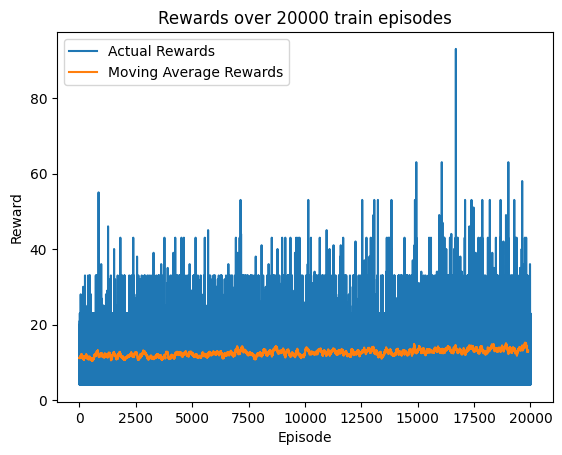

In [268]:
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
n_episodes = 20000
mcc_agent = MCCAgent(env=env, alpha=0.5, gamma=.9)
mcc_agent.train(n_episodes)

print(f"Mean reward: {np.mean(mcc_agent.rewards)}")
print(f"Reward std: {np.std(mcc_agent.rewards)}")

# plot the rewards
plt.plot(mcc_agent.rewards, label='Actual Rewards')
window_size = 100
moving_avg_rewards = np.convolve(mcc_agent.rewards, np.ones(window_size)/window_size, mode='valid')
plt.plot(moving_avg_rewards, label='Moving Average Rewards')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title(f"Rewards over {n_episodes} train episodes")
plt.legend()
plt.show()

In [ ]:
obs, _ = env.reset()

while True:
    action = mcc_agent.policy(obs)

    obs, reward, done, _, info = env.step(action)

    os.system("clear")
    sys.stdout.write(env.render())
    time.sleep(0.2) # FPS

    if done:
        break

print(env.observation_space)

env.close()


100%|██████████| 10000/10000 [00:32<00:00, 310.76it/s]


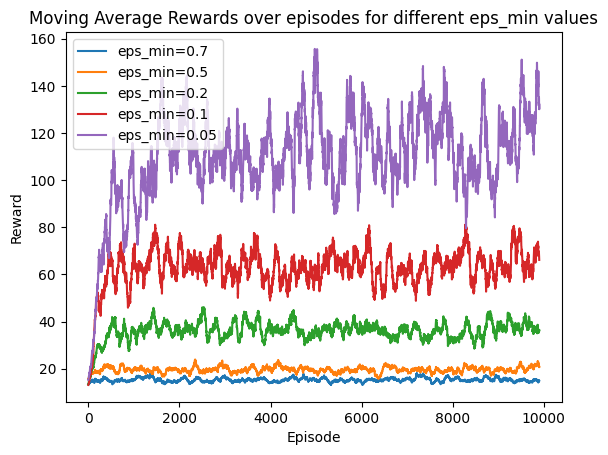

In [270]:
min_epsilons = [0.7, 0.5, 0.2, 0.1, 0.05]
window_size = 100

env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)

for min_eps in min_epsilons:
    n_episodes = 10000

    mcc_agent = MCCAgent(env=env, eps_min=min_eps, eps_decay=.99)
    mcc_agent.train(n_episodes)

    moving_avg_rewards = np.convolve(mcc_agent.rewards, np.ones(window_size)/window_size, mode='valid')
    plt.plot(moving_avg_rewards, label=f'eps_min={min_eps}')

plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Moving Average Rewards over episodes for different eps_min values")
plt.legend()
plt.show()

100%|██████████| 10000/10000 [00:02<00:00, 3352.57it/s]


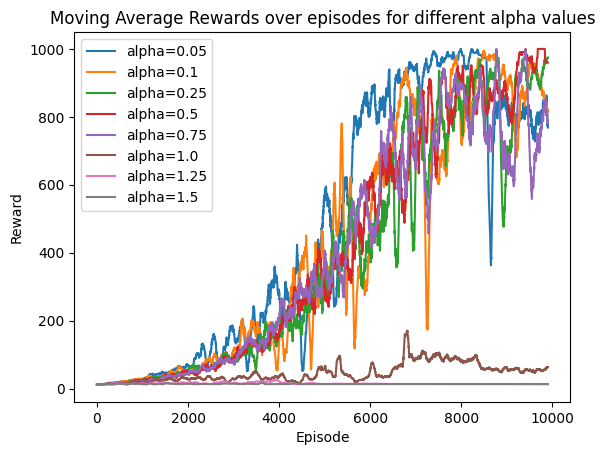

In [466]:
alphas = [0.05, 0.1, 0.25, 0.5, 0.75, 1., 1.25, 1.5]
window_size = 100

env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)

for alpha in alphas:
    n_episodes = 10000

    mcc_agent = MCCAgent(env=env, alpha=alpha, gamma=.999, eps_decay=.999, eps_min=0.00)

    mcc_agent.train(n_episodes)

    moving_avg_rewards = np.convolve(mcc_agent.rewards, np.ones(window_size)/window_size, mode='valid')
    plt.plot(moving_avg_rewards, label=f'alpha={alpha}')

plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Moving Average Rewards over episodes for different alpha values")
plt.legend()
plt.show()

100%|██████████| 50000/50000 [40:59<00:00, 20.33it/s] 


Mean reward: 869.7957
Reward std: 306.0558246488866


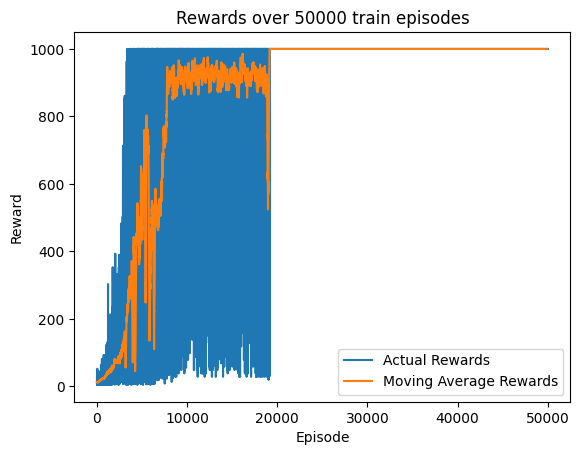

In [ ]:
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
n_episodes = 50000
# mcc_agent = MCCAgent(env=env, alpha=0.5, gamma=.9, eps_min=0.005)
mcc_agent = MCCAgent(env=env, alpha=0.05, gamma=.999, eps_decay=.999, eps_min=0.00)
mcc_agent.train(n_episodes)

print(f"Mean reward: {np.mean(mcc_agent.rewards)}")
print(f"Reward std: {np.std(mcc_agent.rewards)}")

plt.plot(mcc_agent.rewards, label='Actual Rewards')
window_size = 100
moving_avg_rewards = np.convolve(mcc_agent.rewards, np.ones(window_size)/window_size, mode='valid')
plt.plot(moving_avg_rewards, label='Moving Average Rewards')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title(f"Rewards over {n_episodes} train episodes")
plt.legend()
plt.show()

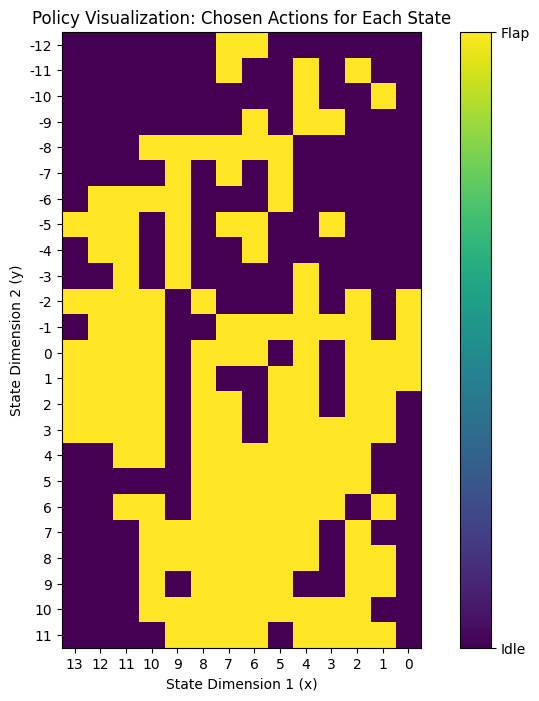

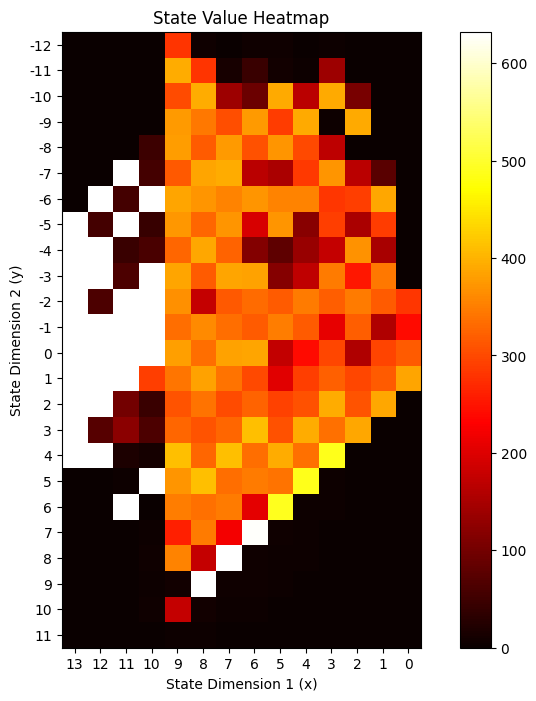

In [ ]:
x_min, x_max = 0, 13
y_min, y_max = -12, 11

state_space = [(x, y) for x in range(x_min, x_max + 1) for y in range(y_min, y_max + 1)]
action_labels = ['Idle', 'Flap']

plot_policy(mcc_agent.policy, state_space, action_labels)
plot_value_function(mcc_agent.Q, state_space)


# SARSA($\lambda$)

In [ ]:
class SarsaLambdaAgent:
    def __init__(self, env, alpha=0.5, gamma=0.9, lam=0.9, eps_start=1.0, eps_decay=.99999, eps_min=0.05, max_steps=1000):
        """
        Sarsa(λ) agent with binary feature vectors indicating dx, dy and action.
        """
        self.env = env
        self.nA = env.action_space.n
        self.nOx = env.observation_space[0].n
        self.nOy = env.observation_space[1].n
        
        self.alpha = alpha
        self.gamma = gamma
        self.lam = lam
        
        self.eps = eps_start
        self.eps_start = eps_start
        self.eps_decay = eps_decay
        self.eps_min = eps_min
        
        
        self.min_x = 0
        self.max_x = 13
        self.min_y = -12
        self.max_y = 11

        self.w = np.zeros(((self.max_x - self.min_x + 1) + (self.max_y - self.min_y + 1)) * self.nA)

        self.rewards = []

        self.max_steps = max_steps
        
    def get_active_features(self, state, action):
        """
        Returns the active features for the given state and action.
        """
        return [state[0] + (self.max_x - self.min_x + 1) * action, (self.max_x - self.min_x + 2) + state[1] + (self.max_y - self.min_y + 1) * action]
    
    def get_q_value(self, state, action):
        """
        Computes Q(s,a) = w^T x(s,a).
        """
        active_feats = self.get_active_features(state, action)
        return np.sum(self.w[active_feats])
    
    def get_probs(self, state, epsilon):
        """
        Epsilon-greedy action probabilities based on the current weights w.
        """
        q_vals = np.array([self.get_q_value(state, a) for a in range(self.nA)])
        
        # Epsilon-greedy distribution
        probs = np.ones(self.nA) * epsilon / self.nA
        best_a = np.argmax(q_vals)
        probs[best_a] += (1.0 - epsilon)
        return probs
    
    def generate_episode(self):
        """
        Generates an episode while performing Sarsa(λ) updates on the fly.
        From section 12.7 of the book.
        """
        cumulative_reward = 0
        
        state, _ = self.env.reset()
        action = np.random.choice(np.arange(self.nA), p=self.get_probs(state, self.eps))
        
        z =  np.zeros(((self.max_x - self.min_x + 1) + (self.max_y - self.min_y + 1)) * self.nA) # Eligibility trace
        
        step = 0
        while True:
                
            next_state, reward, done, _, info = self.env.step(action)
            cumulative_reward += reward
            
            delta = reward

            active_feats = self.get_active_features(state, action)
            for i in active_feats:
                delta = delta - self.w[i]
                z[i] = z[i] + 1.0
            
            if done or step >= self.max_steps:
                self.w = self.w + self.alpha * delta * z
                break
            
            next_action = np.random.choice(np.arange(self.nA), p=self.get_probs(next_state, self.eps))
            
            next_active_feats = self.get_active_features(next_state, next_action)
            for i in next_active_feats:
                delta = delta + self.gamma * self.w[i]
            
            self.w = self.w + self.alpha * delta * z
            z = z * self.gamma * self.lam

            state = next_state
            action = next_action

            step += 1
        self.rewards.append(cumulative_reward)
    
    def train(self, num_episodes):
        for _ in tqdm(range(1, num_episodes + 1)):
            self.eps = max(self.eps * self.eps_decay, self.eps_min)
            self.generate_episode()

        self.Q = defaultdict(lambda: np.zeros(self.nA))
        for state_x in range(14):
            for state_y in range(-12, 12):
                state = (state_x, state_y)
                for action in range(self.nA):
                    self.Q[state][action] = self.get_q_value(state, action)

    def policy(self, state):
        return np.random.choice(np.arange(self.nA), p=self.get_probs(state, 0.))

100%|██████████| 50000/50000 [01:48<00:00, 459.41it/s] 


Mean reward: 73.33472
Reward std: 122.85618243507975


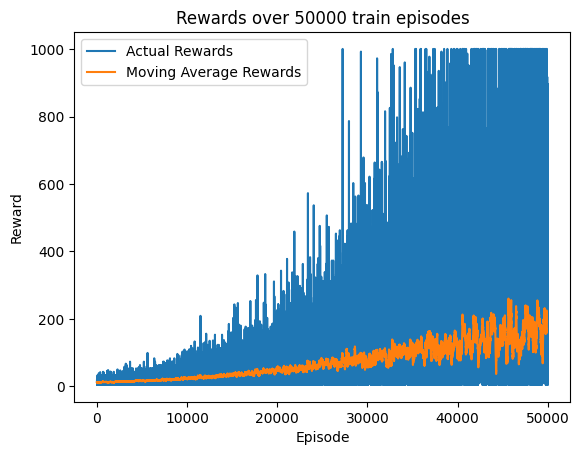

In [ ]:
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
n_episodes = 50000
# sarsa_agent = SarsaLambdaAgent(env=env, alpha=0.2, gamma=.95, lam=0.9, eps_decay=0.99, eps_min=0.)
# sarsa_agent = SarsaLambdaAgent(env=env, alpha=0.1, gamma=.95, lam=0.9, eps_decay=0.99, eps_min=0.)
sarsa_agent = SarsaLambdaAgent(env=env, alpha=.05, gamma=.95, lam=0.999, eps_decay=0.9999, eps_min=0.)

sarsa_agent.train(n_episodes)


print(f"Mean reward: {np.mean(sarsa_agent.rewards)}")
print(f"Reward std: {np.std(sarsa_agent.rewards)}")

plt.plot(sarsa_agent.rewards, label='Actual Rewards')
window_size = 100
moving_avg_rewards = np.convolve(sarsa_agent.rewards, np.ones(window_size)/window_size, mode='valid')
plt.plot(moving_avg_rewards, label='Moving Average Rewards')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title(f"Rewards over {n_episodes} train episodes")
plt.legend()
plt.show()

In [ ]:
obs, _ = env.reset()

while True:
    action = sarsa_agent.policy(obs)  # for an agent, action = agent.policy(observation)

    obs, reward, done, _, info = env.step(action)

    os.system("clear")
    sys.stdout.write(env.render())
    time.sleep(0.05) # FPS

    if done:
        break

print(env.observation_space)

env.close()


100%|██████████| 50000/50000 [02:01<00:00, 410.72it/s] 


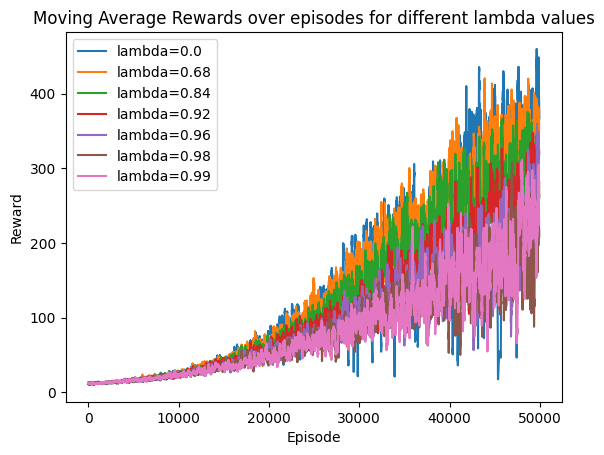

In [464]:
lambdas= [0., 0.68, 0.84, 0.92, 0.96, 0.98, 0.99]
window_size = 100

env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)

for lam in lambdas:
    n_episodes = 50000

    sarsa_agent = SarsaLambdaAgent(env=env, alpha=.05, gamma=.95, lam=lam, eps_decay=0.9999, eps_min=0.)
    sarsa_agent.train(n_episodes)

    moving_avg_rewards = np.convolve(sarsa_agent.rewards, np.ones(window_size)/window_size, mode='valid')
    plt.plot(moving_avg_rewards, label=f'lambda={lam}')

plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Moving Average Rewards over episodes for different lambda values")
plt.legend()
plt.show()

 32%|███▏      | 3242/10000 [00:01<00:02, 2890.90it/s]/var/folders/4h/87blx11d2cnc6zc386sf462h0000gn/T/ipykernel_38672/2934807029.py:126: RuntimeWarning: overflow encountered in multiply
  self.w = self.w + self.alpha * delta * z
/var/folders/4h/87blx11d2cnc6zc386sf462h0000gn/T/ipykernel_38672/2934807029.py:126: RuntimeWarning: overflow encountered in add
  self.w = self.w + self.alpha * delta * z
/var/folders/4h/87blx11d2cnc6zc386sf462h0000gn/T/ipykernel_38672/2934807029.py:126: RuntimeWarning: invalid value encountered in multiply
  self.w = self.w + self.alpha * delta * z
/var/folders/4h/87blx11d2cnc6zc386sf462h0000gn/T/ipykernel_38672/2934807029.py:126: RuntimeWarning: invalid value encountered in add
  self.w = self.w + self.alpha * delta * z
  9%|▉         | 905/10000 [00:00<00:03, 2926.68it/s]/var/folders/4h/87blx11d2cnc6zc386sf462h0000gn/T/ipykernel_38672/2934807029.py:117: RuntimeWarning: overflow encountered in multiply
  self.w = self.w + self.alpha * delta * z
/Users/paul/.

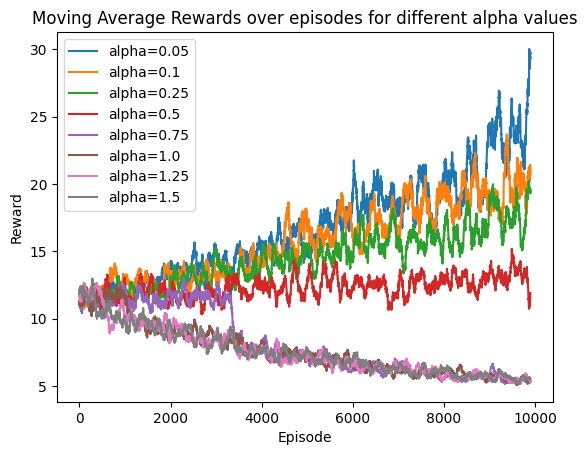

In [470]:
alphas = [0.05, 0.1, 0.25, 0.5, 0.75, 1., 1.25, 1.5]
window_size = 100

env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)

for alpha in alphas:
    n_episodes = 10000

    sarsa_agent = SarsaLambdaAgent(env=env, alpha=alpha, gamma=.95, lam=lam, eps_decay=0.9999, eps_min=0.)
    sarsa_agent.train(n_episodes)

    moving_avg_rewards = np.convolve(sarsa_agent.rewards, np.ones(window_size)/window_size, mode='valid')
    plt.plot(moving_avg_rewards, label=f'alpha={alpha}')

plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Moving Average Rewards over episodes for different alpha values")
plt.legend()
plt.show()

100%|██████████| 100000/100000 [13:47<00:00, 120.90it/s]


Mean reward: 280.02466
Reward std: 331.7665826629988


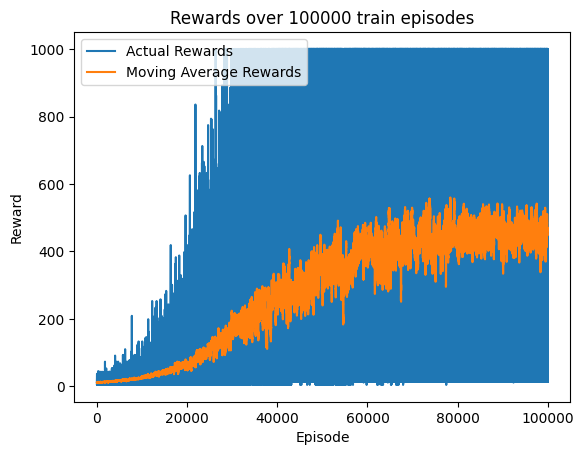

In [ ]:
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
n_episodes = 100000
# sarsa_agent = SarsaLambdaAgent(env=env, alpha=0.2, gamma=.95, lam=0.9, eps_decay=0.99, eps_min=0.)
# sarsa_agent = SarsaLambdaAgent(env=env, alpha=0.1, gamma=.95, lam=0.9, eps_decay=0.99, eps_min=0.)
sarsa_agent = SarsaLambdaAgent(env=env, alpha=.05, gamma=.95, lam=0.68, eps_decay=0.9999, eps_min=0.)

sarsa_agent.train(n_episodes)


print(f"Mean reward: {np.mean(sarsa_agent.rewards)}")
print(f"Reward std: {np.std(sarsa_agent.rewards)}")

plt.plot(sarsa_agent.rewards, label='Actual Rewards')
window_size = 100
moving_avg_rewards = np.convolve(sarsa_agent.rewards, np.ones(window_size)/window_size, mode='valid')
plt.plot(moving_avg_rewards, label='Moving Average Rewards')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title(f"Rewards over {n_episodes} train episodes")
plt.legend()
plt.show()

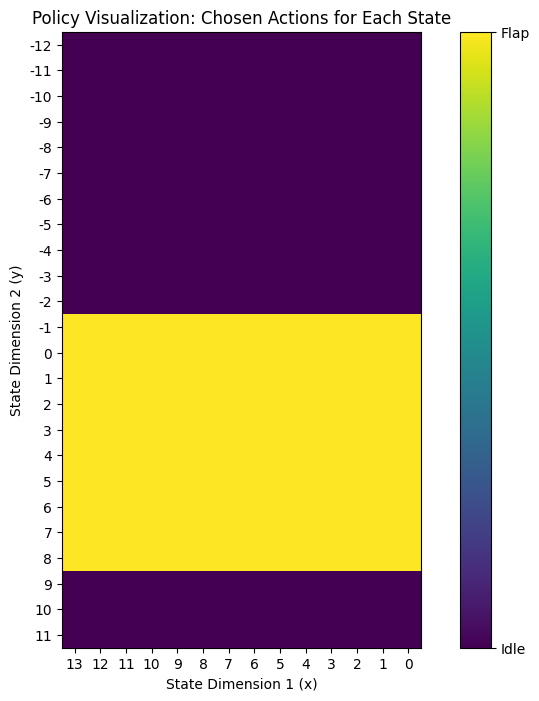

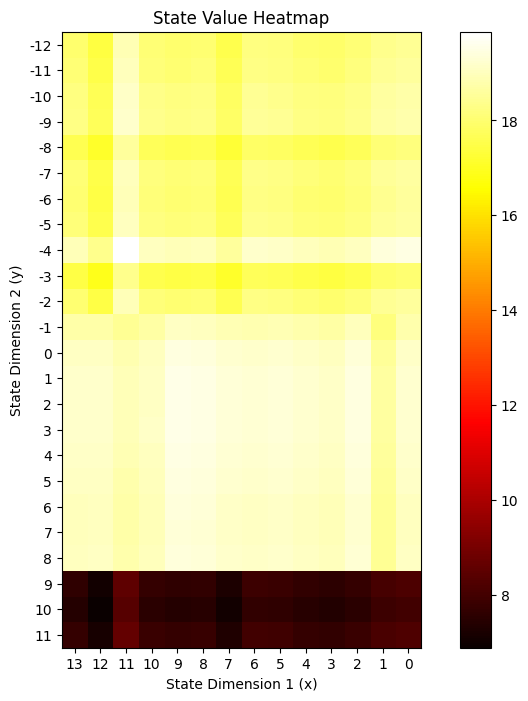

In [492]:
plot_policy(sarsa_agent.policy, state_space, action_labels)
plot_value_function(sarsa_agent.Q, state_space)

# Experiments on other environments

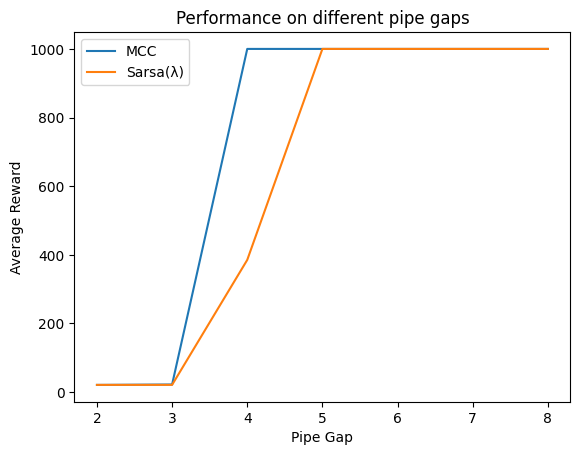

In [505]:
# Check performance on other envs

pipe_gaps = [2, 3, 4, 5, 6, 7, 8]
window_size = 100

rewards_mcc = []
rewards_sarsa = []

for pipe_gap in pipe_gaps:
    env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=pipe_gap)
    n_episodes = 100

    tot_rewards_mcc = 0
    tot_rewards_sarsa = 0

    for _ in range(n_episodes):
        
        obs, _ = env.reset()
        
        for _ in range(1000):
            action = mcc_agent.policy(obs)
            obs, reward, done, _, _ = env.step(action)
            if done:
                break
            tot_rewards_mcc += reward

        obs, _ = env.reset()
        for _ in range(1000):
            action = sarsa_agent.policy(obs)
            obs, reward, done, _, _ = env.step(action)
            if done:
                break
            tot_rewards_sarsa += reward

    rewards_mcc.append(tot_rewards_mcc / n_episodes)
    rewards_sarsa.append(tot_rewards_sarsa / n_episodes)

plt.plot(pipe_gaps, rewards_mcc, label='MCC')
plt.plot(pipe_gaps, rewards_sarsa, label='Sarsa(λ)')
plt.xlabel("Pipe Gap")
plt.ylabel("Average Reward")
plt.title("Performance on different pipe gaps")
plt.legend()
plt.show()

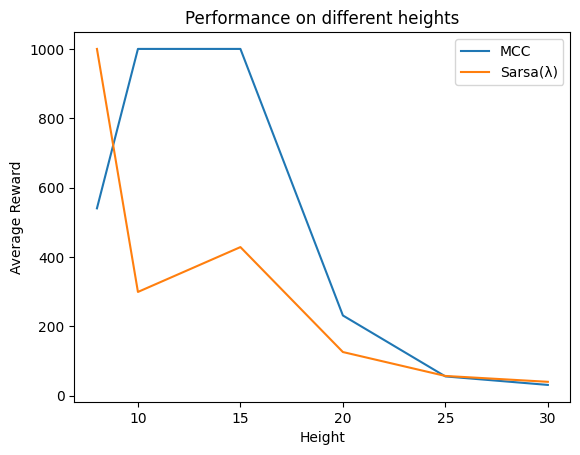

In [506]:
heights = [8, 10, 15, 20, 25, 30]
window_size = 100

rewards_mcc = []
rewards_sarsa = []

for height in heights:
    env = gym.make('TextFlappyBird-v0', height=height, width=20, pipe_gap=4)
    n_episodes = 100

    tot_rewards_mcc = 0
    tot_rewards_sarsa = 0

    for _ in range(n_episodes):
        
        obs, _ = env.reset()
        
        for _ in range(1000):
            action = mcc_agent.policy(obs)
            obs, reward, done, _, _ = env.step(action)
            if done:
                break
            tot_rewards_mcc += reward

        obs, _ = env.reset()
        for _ in range(1000):
            action = sarsa_agent.policy(obs)
            obs, reward, done, _, _ = env.step(action)
            if done:
                break
            tot_rewards_sarsa += reward

    rewards_mcc.append(tot_rewards_mcc / n_episodes)
    rewards_sarsa.append(tot_rewards_sarsa / n_episodes)

plt.plot(heights, rewards_mcc, label='MCC')
plt.plot(heights, rewards_sarsa, label='Sarsa(λ)')
plt.xlabel("Height")
plt.ylabel("Average Reward")
plt.title("Performance on different heights")
plt.legend()
plt.show()

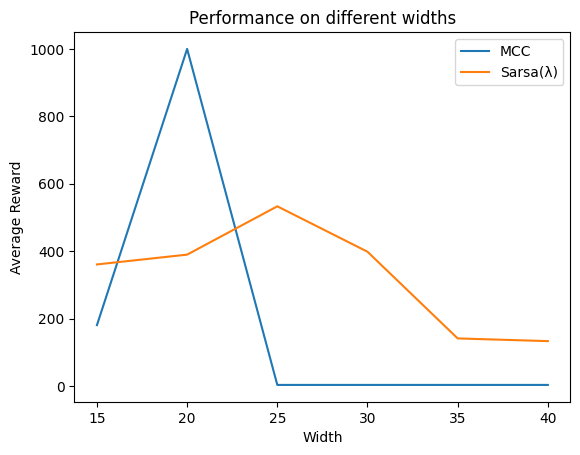

In [507]:
widths = [15, 20, 25, 30, 35, 40]
window_size = 100

rewards_mcc = []
rewards_sarsa = []

for width in widths:
    env = gym.make('TextFlappyBird-v0', height=15, width=width, pipe_gap=4)
    n_episodes = 100

    tot_rewards_mcc = 0
    tot_rewards_sarsa = 0

    for _ in range(n_episodes):
        
        obs, _ = env.reset()
        
        for _ in range(1000):
            action = mcc_agent.policy(obs)
            obs, reward, done, _, _ = env.step(action)
            if done:
                break
            tot_rewards_mcc += reward

        obs, _ = env.reset()
        for _ in range(1000):
            action = sarsa_agent.policy(obs)
            obs, reward, done, _, _ = env.step(action)
            if done:
                break
            tot_rewards_sarsa += reward

    rewards_mcc.append(tot_rewards_mcc / n_episodes)
    rewards_sarsa.append(tot_rewards_sarsa / n_episodes)

plt.plot(widths, rewards_mcc, label='MCC')
plt.plot(widths, rewards_sarsa, label='Sarsa(λ)')
plt.xlabel("Width")
plt.ylabel("Average Reward")
plt.title("Performance on different widths")
plt.legend()
plt.show()